In [26]:
import h5py
import numpy as np
import pandas as pd
import numpy as np

file_path = '/Users/rizq/projects/roaddata/ROAD_dataset.h5'

In [2]:
train = 'train_data/data'
test = 'test_data/data'

train_indices = 0
test_indices = 0
anomalyGroups = []

In [3]:
with h5py.File(file_path, 'r') as hf:
  train_indices = len(hf[train])
  test_indices = len(hf[test])

  for k in hf['anomaly_data'].keys():
    anomalyGroups.append(k)
  print(anomalyGroups)

['first_order_data_loss', 'first_order_high_noise', 'galactic_plane', 'lightning', 'oscillating_tile', 'rfi_ionosphere_reflect', 'solar_storm', 'source_in_sidelobes', 'third_order_data_loss']


In [4]:
print(train_indices)
print(test_indices)

3687
1000


In [5]:
anomalyTrainGroupDict = {}
anomalyTestGroupDict = {}

In [6]:
import torch
from torch.utils.data import random_split

with h5py.File(file_path, 'r') as hf:

  for k in hf['anomaly_data'].keys():
    dataset = hf['anomaly_data'][k]['data']
    #print(k)

    # Define the sizes of the splits
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size

    # Split the dataset into training and testing sets
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    anomalyTrainGroupDict[k] = train_dataset.indices
    anomalyTestGroupDict[k] = test_dataset.indices

    #print(test_dataset.indices)

In [8]:
trainPaths = []
testPaths = []
for i in range(train_indices):
  tup = ('train_data', i)
  trainPaths.append(tup)

for i in range(test_indices):
  tup = ('test_data', i)
  testPaths.append(tup)

for k in anomalyTrainGroupDict.keys():
  for idx in anomalyTrainGroupDict[k]:
    tup = (f'anomaly_data/{k}', idx)
    trainPaths.append(tup)

for k in anomalyTestGroupDict.keys():
  for idx in anomalyTestGroupDict[k]:
    tup = (f'anomaly_data/{k}', idx)
    testPaths.append(tup)

In [9]:
print(len(trainPaths))
print(len(testPaths))

5575
1478


In [11]:
import random

random.shuffle(trainPaths)
random.shuffle(testPaths)
#print(trainPaths)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Set device to GPU if available, otherwise use CPU
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set device to MPS (Apple Silicon) if available, otherwise use CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [23]:
from torch.utils.data import Dataset, DataLoader

class H5Dataset(Dataset):
    def __init__(self, paths, hf, transform=None):
        """
        paths: A list of tuples (path, index)
        transform: Optional transform to be applied on a sample.
        """
        self.paths = paths
        self.transform = transform
        self.hf = hf

        self.anomaly_mapping = {
            "first_order_data_loss": 1,
            "first_order_high_noise": 2,
            "galactic_plane": 3,
            "lightning": 4,
            "oscillating_tile": 5,
            "rfi_ionosphere_reflect": 6,
            "solar_storm": 7,
            "source_in_sidelobes": 8,
            "third_order_data_loss": 9
        }

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        path, index = self.paths[i]
        #print(path)

        # Open the file and retrieve the sample and label on the fly
        #with h5py.File(file_path, 'r') as hf:
            # Extract the data sample and label using the index
        data = hf[f'{path}/data'][index]
        label = hf[f'{path}/labels'][index]

        # Optionally apply a transformation to the data sample
        if self.transform:
            data = self.transform(data)

        # Convert sample to a tensor
        data = torch.tensor(data, dtype=torch.float32)

        data = data.permute(2, 0, 1)

        if isinstance(label, (np.bytes_, bytes)):
            label = label.decode('utf-8')

        if label == '':
            label_int = 0
            #print('normal')
        else:
            label = path.split("/")[-1]
            if label in self.anomaly_mapping:
                label_int = self.anomaly_mapping[label]
                #print(f"label = {label}")
            else:
                raise ValueError(f"Label {label} not found in mapping dictionary!")


        label_int = torch.tensor(label_int, dtype=torch.long)

        return data, label_int

Starting hyperparameter tuning...

Experiment 1/32: lr=0.001, batch_size=16, filters=16, kernel_size=3, dropout=0.0


Test Accuracy: 0.7077 -- Model saved as checkpoints/model_lr0.001_bs16_f16_k3_d0.0.pth

Experiment 2/32: lr=0.001, batch_size=16, filters=16, kernel_size=3, dropout=0.5


Test Accuracy: 0.7057 -- Model saved as checkpoints/model_lr0.001_bs16_f16_k3_d0.5.pth

Experiment 3/32: lr=0.001, batch_size=16, filters=16, kernel_size=5, dropout=0.0


Test Accuracy: 0.6982 -- Model saved as checkpoints/model_lr0.001_bs16_f16_k5_d0.0.pth

Experiment 4/32: lr=0.001, batch_size=16, filters=16, kernel_size=5, dropout=0.5


Test Accuracy: 0.7341 -- Model saved as checkpoints/model_lr0.001_bs16_f16_k5_d0.5.pth

Experiment 5/32: lr=0.001, batch_size=16, filters=32, kernel_size=3, dropout=0.0


Test Accuracy: 0.3484 -- Model saved as checkpoints/model_lr0.001_bs16_f32_k3_d0.0.pth

Experiment 6/32: lr=0.001, batch_size=16, filters=32, kernel_size=3, dropout=0.5


Test Accuracy: 0.7192 -- Model saved as checkpoints/model_lr0.001_bs16_f32_k3_d0.5.pth

Experiment 7/32: lr=0.001, batch_size=16, filters=32, kernel_size=5, dropout=0.0


Test Accuracy: 0.7388 -- Model saved as checkpoints/model_lr0.001_bs16_f32_k5_d0.0.pth

Experiment 8/32: lr=0.001, batch_size=16, filters=32, kernel_size=5, dropout=0.5


Test Accuracy: 0.7395 -- Model saved as checkpoints/model_lr0.001_bs16_f32_k5_d0.5.pth

Experiment 9/32: lr=0.001, batch_size=32, filters=16, kernel_size=3, dropout=0.0


Test Accuracy: 0.6800 -- Model saved as checkpoints/model_lr0.001_bs32_f16_k3_d0.0.pth

Experiment 10/32: lr=0.001, batch_size=32, filters=16, kernel_size=3, dropout=0.5


Test Accuracy: 0.7023 -- Model saved as checkpoints/model_lr0.001_bs32_f16_k3_d0.5.pth

Experiment 11/32: lr=0.001, batch_size=32, filters=16, kernel_size=5, dropout=0.0


Test Accuracy: 0.6827 -- Model saved as checkpoints/model_lr0.001_bs32_f16_k5_d0.0.pth

Experiment 12/32: lr=0.001, batch_size=32, filters=16, kernel_size=5, dropout=0.5


Test Accuracy: 0.7476 -- Model saved as checkpoints/model_lr0.001_bs32_f16_k5_d0.5.pth

Experiment 13/32: lr=0.001, batch_size=32, filters=32, kernel_size=3, dropout=0.0


Test Accuracy: 0.7192 -- Model saved as checkpoints/model_lr0.001_bs32_f32_k3_d0.0.pth

Experiment 14/32: lr=0.001, batch_size=32, filters=32, kernel_size=3, dropout=0.5


Test Accuracy: 0.6915 -- Model saved as checkpoints/model_lr0.001_bs32_f32_k3_d0.5.pth

Experiment 15/32: lr=0.001, batch_size=32, filters=32, kernel_size=5, dropout=0.0


Test Accuracy: 0.6103 -- Model saved as checkpoints/model_lr0.001_bs32_f32_k5_d0.0.pth

Experiment 16/32: lr=0.001, batch_size=32, filters=32, kernel_size=5, dropout=0.5


Test Accuracy: 0.1590 -- Model saved as checkpoints/model_lr0.001_bs32_f32_k5_d0.5.pth

Experiment 17/32: lr=0.0005, batch_size=16, filters=16, kernel_size=3, dropout=0.0


Test Accuracy: 0.6861 -- Model saved as checkpoints/model_lr0.0005_bs16_f16_k3_d0.0.pth

Experiment 18/32: lr=0.0005, batch_size=16, filters=16, kernel_size=3, dropout=0.5


Test Accuracy: 0.6982 -- Model saved as checkpoints/model_lr0.0005_bs16_f16_k3_d0.5.pth

Experiment 19/32: lr=0.0005, batch_size=16, filters=16, kernel_size=5, dropout=0.0


Test Accuracy: 0.7300 -- Model saved as checkpoints/model_lr0.0005_bs16_f16_k5_d0.0.pth

Experiment 20/32: lr=0.0005, batch_size=16, filters=16, kernel_size=5, dropout=0.5


Test Accuracy: 0.7145 -- Model saved as checkpoints/model_lr0.0005_bs16_f16_k5_d0.5.pth

Experiment 21/32: lr=0.0005, batch_size=16, filters=32, kernel_size=3, dropout=0.0


Test Accuracy: 0.7307 -- Model saved as checkpoints/model_lr0.0005_bs16_f32_k3_d0.0.pth

Experiment 22/32: lr=0.0005, batch_size=16, filters=32, kernel_size=3, dropout=0.5


Test Accuracy: 0.7158 -- Model saved as checkpoints/model_lr0.0005_bs16_f32_k3_d0.5.pth

Experiment 23/32: lr=0.0005, batch_size=16, filters=32, kernel_size=5, dropout=0.0


Test Accuracy: 0.7327 -- Model saved as checkpoints/model_lr0.0005_bs16_f32_k5_d0.0.pth

Experiment 24/32: lr=0.0005, batch_size=16, filters=32, kernel_size=5, dropout=0.5


Test Accuracy: 0.7158 -- Model saved as checkpoints/model_lr0.0005_bs16_f32_k5_d0.5.pth

Experiment 25/32: lr=0.0005, batch_size=32, filters=16, kernel_size=3, dropout=0.0


Test Accuracy: 0.6834 -- Model saved as checkpoints/model_lr0.0005_bs32_f16_k3_d0.0.pth

Experiment 26/32: lr=0.0005, batch_size=32, filters=16, kernel_size=3, dropout=0.5


Test Accuracy: 0.6766 -- Model saved as checkpoints/model_lr0.0005_bs32_f16_k3_d0.5.pth

Experiment 27/32: lr=0.0005, batch_size=32, filters=16, kernel_size=5, dropout=0.0


Test Accuracy: 0.4655 -- Model saved as checkpoints/model_lr0.0005_bs32_f16_k5_d0.0.pth

Experiment 28/32: lr=0.0005, batch_size=32, filters=16, kernel_size=5, dropout=0.5


Test Accuracy: 0.6982 -- Model saved as checkpoints/model_lr0.0005_bs32_f16_k5_d0.5.pth

Experiment 29/32: lr=0.0005, batch_size=32, filters=32, kernel_size=3, dropout=0.0


Test Accuracy: 0.6976 -- Model saved as checkpoints/model_lr0.0005_bs32_f32_k3_d0.0.pth

Experiment 30/32: lr=0.0005, batch_size=32, filters=32, kernel_size=3, dropout=0.5


Test Accuracy: 0.7050 -- Model saved as checkpoints/model_lr0.0005_bs32_f32_k3_d0.5.pth

Experiment 31/32: lr=0.0005, batch_size=32, filters=32, kernel_size=5, dropout=0.0


Test Accuracy: 0.4046 -- Model saved as checkpoints/model_lr0.0005_bs32_f32_k5_d0.0.pth

Experiment 32/32: lr=0.0005, batch_size=32, filters=32, kernel_size=5, dropout=0.5


Test Accuracy: 0.7145 -- Model saved as checkpoints/model_lr0.0005_bs32_f32_k5_d0.5.pth

Hyperparameter Tuning Results:
        lr  batch_size  base_filters  kernel_size  dropout_rate  \
0   0.0010          16            16            3           0.0   
1   0.0010          16            16            3           0.5   
2   0.0010          16            16            5           0.0   
3   0.0010          16            16            5           0.5   
4   0.0010          16            32            3           0.0   
5   0.0010          16            32            3           0.5   
6   0.0010          16            32            5           0.0   
7   0.0010          16            32            5           0.5   
8   0.0010          32            16            3           0.0   
9   0.0010          32            16            3           0.5   
10  0.0010          32            16            5           0.0   
11  0.0010          32            16            5           0.5   
12  0.001

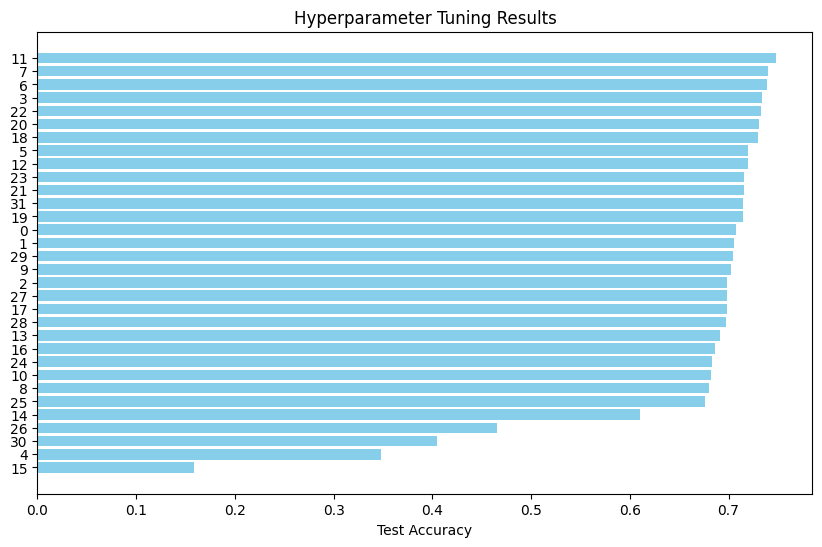

In [25]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set the device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# =============================================================================
# Define the CNN Model that accepts hyperparameters
# =============================================================================
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=10, base_filters=16, kernel_size=3, dropout_rate=0.0):
        """
        num_classes: Total number of classes (0 for normal and 1-9 for anomalies)
        base_filters: Number of filters for the first convolution layer.
        kernel_size: Convolution kernel size (assumed square).
        dropout_rate: Dropout probability.
        """
        super(CNNClassifier, self).__init__()
        padding = kernel_size // 2  # this keeps the spatial dimensions
        # First conv block
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=base_filters, kernel_size=kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(base_filters)
        self.pool = nn.MaxPool2d(2)
        
        # Second conv block (doubling filters)
        self.conv2 = nn.Conv2d(in_channels=base_filters, out_channels=base_filters * 2, kernel_size=kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(base_filters * 2)
        
        # Third conv block (doubling again)
        self.conv3 = nn.Conv2d(in_channels=base_filters * 2, out_channels=base_filters * 4, kernel_size=kernel_size, padding=padding)
        self.bn3 = nn.BatchNorm2d(base_filters * 4)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)
        
        # Global average pooling layer
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layer
        self.fc = nn.Linear(base_filters * 4, num_classes)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# =============================================================================
# Data Preparation Helpers
# =============================================================================
# Assuming train_dataset and test_dataset are already defined.
# Example:
# train_dataset = YourCustomH5Dataset(trainPaths, transform=your_transforms)
# test_dataset  = YourCustomH5Dataset(testPaths, transform=your_transforms)
hf = h5py.File(file_path, 'r')
train_dataset = H5Dataset(paths=trainPaths, hf=hf)
test_dataset = H5Dataset(paths=testPaths, hf=hf)

def get_data_loaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    return train_loader, test_loader

# =============================================================================
# Training and Evaluation Function
# =============================================================================
def train_and_evaluate(lr, batch_size, base_filters, kernel_size, dropout_rate, num_epochs=3):
    """
    Trains a model with the specified hyperparameters for num_epochs (default 3) and evaluates its accuracy.
    Returns a tuple of (test_accuracy, model_state_dict).
    """
    train_loader, test_loader = get_data_loaders(batch_size)
    
    # Initialize the model with provided hyperparameters
    model = CNNClassifier(num_classes=10, base_filters=base_filters, kernel_size=kernel_size, dropout_rate=dropout_rate)
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix(loss=loss.item())
    
    # Evaluation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    accuracy = correct / total
    return accuracy, model.state_dict()

# =============================================================================
# Hyperparameter Tuning Loop with Periodic Checkpointing
# =============================================================================
# Hyperparameter grid
learning_rates = [1e-3, 5e-4]
batch_sizes = [16, 32]
base_filters_list = [16, 32]
kernel_sizes = [3, 5]
dropout_rates = [0.0, 0.5]

# All hyperparameter combinations
hyperparam_combinations = list(itertools.product(learning_rates, batch_sizes, base_filters_list, kernel_sizes, dropout_rates))

# Create directory for model checkpoints
checkpoint_dir = "checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

results = []
print("Starting hyperparameter tuning...")

# Loop over hyperparameter combinations
for idx, (lr, batch_size, base_filters, kernel_size, dropout_rate) in enumerate(hyperparam_combinations):
    print(f"\nExperiment {idx+1}/{len(hyperparam_combinations)}: lr={lr}, batch_size={batch_size}, filters={base_filters}, kernel_size={kernel_size}, dropout={dropout_rate}")
    
    test_acc, model_state = train_and_evaluate(lr, batch_size, base_filters, kernel_size, dropout_rate, num_epochs=3)
    
    # Save model checkpoint with filename encoding hyperparameters.
    model_filename = f"model_lr{lr}_bs{batch_size}_f{base_filters}_k{kernel_size}_d{dropout_rate}.pth"
    model_save_path = os.path.join(checkpoint_dir, model_filename)
    torch.save(model_state, model_save_path)
    
    # Record results along with the model checkpoint path.
    results.append({
        "lr": lr,
        "batch_size": batch_size,
        "base_filters": base_filters,
        "kernel_size": kernel_size,
        "dropout_rate": dropout_rate,
        "test_accuracy": test_acc,
        "model_path": model_save_path
    })
    
    print(f"Test Accuracy: {test_acc:.4f} -- Model saved as {model_save_path}")
    
    # Save intermediate results to CSV after each experiment.
    results_df = pd.DataFrame(results)
    results_df.to_csv("hyperparam_tuning_results.csv", index=False)

# =============================================================================
# Final Results Table and Plot
# =============================================================================
results_df = pd.DataFrame(results)
print("\nHyperparameter Tuning Results:")
print(results_df)

results_df_sorted = results_df.sort_values(by="test_accuracy", ascending=False)
print("\nBest Hyperparameters:")
print(results_df_sorted.head())

plt.figure(figsize=(10,6))
plt.barh(results_df_sorted.index.astype(str), results_df_sorted['test_accuracy'], color='skyblue')
plt.xlabel("Test Accuracy")
plt.title("Hyperparameter Tuning Results")
plt.gca().invert_yaxis()
plt.show()


# close the file
hf.close()